## This notebook has the goal of testing diffrent Model Selection Methods

For each method, L2-norm will be used as a preprocesing step.
The main test will be to plot the different Mu-values for the different model-selection, and a success is if the mu's have distinct shape, and are not just shifted

In [1]:
import torch
import glob
import matplotlib.pyplot as plt
from MFA import MFA
from utils import get_data, reconstruct_mfa, calculate_rmse, calculate_sam
from enum import Enum
import matplotlib.pyplot as plt
from hypso import Hypso
import numpy as np

These are the setup variables for the model:

In [2]:
class DataProduct(Enum):
    L1A = 'l1a'
    L1B = 'l1b'
    L1D = 'l1d'

In [3]:
data_product = DataProduct.L1D

In [4]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_dir = glob.glob(f'data/training_{data_product.value}/*.nc')
print(f"Found {len(data_dir)} files.")

Using device: cpu
Found 44 files.


In [5]:
target_total_samples = 200000

data_list = get_data(data_dir, data_product.value, target_total_samples)

data = torch.from_numpy(data_list).float().to(device)

Aiming to extract ~4545 pixels per file from 44 files to reach a total of ~200000 samples.
1/44 | File: data/training_l1d\aeronetgalata_2025-01-02T08-18-16Z-l1d.nc | Extracted 4545 pixels.
2/44 | File: data/training_l1d\algeria_2022-10-29T09-44-03Z-l1d.nc | Extracted 4545 pixels.
3/44 | File: data/training_l1d\amazonia_2024-09-21T13-12-47Z-l1d.nc | Extracted 4545 pixels.
4/44 | File: data/training_l1d\annapolis_2025-08-04T15-25-40Z-l1d.nc | Extracted 4545 pixels.
5/44 | File: data/training_l1d\antarctica_2022-11-20T08-44-35Z-l1d.nc | Extracted 4545 pixels.
6/44 | File: data/training_l1d\barfire_2025-08-04T09-11-36Z-l1d.nc | Extracted 4545 pixels.
7/44 | File: data/training_l1d\bermuda_2024-07-16T14-27-21Z-l1d.nc | Extracted 4545 pixels.
8/44 | File: data/training_l1d\blacksea2_2024-07-21T07-40-44Z-l1d.nc | Extracted 4545 pixels.
9/44 | File: data/training_l1d\capedyer_2023-10-16T14-54-55Z-l1d.nc | Extracted 4545 pixels.
10/44 | File: data/training_l1d\capescott_2023-05-09T19-29-59Z-l1d

## Look for outliers or dead pixels

Iterating over the pixels to see if any are all zero or all max

In [6]:
# We check if ALL values along the last dimension (bands) are 0
dead_pixel_mask = (data == 0).all(dim=-1)

# Get the indices/coordinates of the dead pixels
dead_pixel_indices = torch.nonzero(dead_pixel_mask)

# Check how many dead pixels were found
print(f"Number of dead pixels: {dead_pixel_indices.shape[0]}")

Number of dead pixels: 0


## Making the MFA Model

### Model Selection
Determining the optimal model order—specifically the number of mixture components ($K$) and the dimensionality of the latent factor space ($q$)—is a critical step to prevent overfitting. The literature emphasizes two primary methods for this selection process:
1. **The Information Criteria Approach (BIC)**

Source: McLachlan, G., & Peel, D. (2000). *Finite Mixture Models.*

This approach involves performing a grid search over potential $(K, q)$ combinations. For each combination, we calculate the Bayesian Information Criterion (BIC) and select the pair with the lowest BIC score. This metric balances goodness-of-fit with model complexity:$$\text{BIC} = -2 \ln(\mathcal{L}) + d \ln(n)$$
Where:
$\mathcal{L}$ is the maximized likelihood of the model.
$d$ is the number of free parameters.
$n$ is the number of observations.

2. **The Log Likelyhood Approach (LL)**

This approach involves performing a grid search over potential $(K, q)$ combinations. For each combination, we calculate the Log-Likelyhood (LL) and select the pair with the highest LL. Intuitivly, the Log-Likelyhood is the logarithm of the likelyhood of observing the data, given the model?

3. **Integrated Completed Likelihood (ICL)**
Source: Biernacki, C., Celeux, G., & Govaert, G. (2000). Assessing a mixture model for clustering with the integrated completed likelihood.

While the Bayesian Information Criterion (BIC) is standard for density estimation, Biernacki et al. (2000) demonstrate that it frequently overestimates model complexity in clustering applications by failing to penalize overlapping components. To ensure distinct, physically meaningful material classes, this study utilizes the Integrated Completed Likelihood (ICL) criterion, which extends BIC by incorporating an entropy penalty to strictly favor well-separated clusters.

4. **The Variational Bayesian Approach (VB)**

Source: Ghahramani, Z., & Beal, M. J. (2000). *Variational Inference for Bayesian Mixtures of Factor Analysers.*

Unlike the BIC grid search, the Variational Bayesian method treats model selection as an integral part of the optimization process itself, rather than a post-hoc comparison.
Mechanism: It places Dirichlet priors on the mixing coefficients and Automatic Relevance Determination (ARD) priors on the factor loading matrices.
Result: As the model trains, it automatically drives the coefficients of unnecessary components or factors to zero, effectively selecting the model structure in a single run.



## Choosen approach
1. Perform PCA on the entire dataset. If a single PCA model can describe >99.5% of the variance with *N* number of components, then we set *N* as the ceiling for our BIC-method. Source: Bioucas-Dias, J. M., & Nascimento, J. M. (2008). *Hyperspectral Subspace Identification.*

2. Sample a subset of the pixels 10,000 - 50,000 pixels. Source: Banfield, J. D., & Raftery, A. E. (1993). *Model-Based Gaussian and Non-Gaussian Clustering.*

3. Perform the grid search on the sampled pixels. and use the different methods!

4. Retrain the optimal combinantion on the complete dataset.

### 2. Subsample the dataset

In [7]:
N_SUBSET = 50000 
torch.manual_seed(42)

# Generate random indices
if data.shape[0] > N_SUBSET:
    # random_split or randperm is standard torch practice
    indices = torch.randperm(data.shape[0])[:N_SUBSET]
    data_subset = data[indices]
    print(f"Subsampled data from {data.shape[0]} to {data_subset.shape[0]} samples.")
else:
    print("Dataset smaller than requested subset. Using full data.")
    data_subset = data

print(f"Subset shape: {data_subset.shape}")

Subsampled data from 199980 to 50000 samples.
Subset shape: torch.Size([50000, 120])


### Perform Grid Search

We hold out 20% of the training-samples, and train the MFA on the remainding 90%. For each batch, we calculate the out-of-sample log-likelyhood of the model explaining the pixels. 

In [ ]:
torch.manual_seed(42)

# Grid Configuration
k_range = range(3, 14, 1)
# Calculate ceiling and add safety buffer (Assuming n_components_995 is defined earlier)
q_ceiling = 10
q_range = range(2, q_ceiling + 1) 

# Split into Train/Test (80/20)
train_size = int(0.8 * len(data_subset))
test_size = len(data_subset) - train_size
X_train_dataset, X_test_dataset = torch.utils.data.random_split(data_subset, [train_size, test_size])

# Extract the actual tensors from the Subset objects
X_train = data_subset[X_train_dataset.indices]
X_test = data_subset[X_test_dataset.indices]

print(f"Starting Out-of-Sample Log-Likelihood Grid Search.")
print(f"Training on {len(X_train)} samples, Testing on {len(X_test)} samples.")

#print("Applying L2 Normalization to data")
#norms = torch.norm(X_train, p=2, dim=1, keepdim=True)
#epsilon = 1e-8
#X_train_processed = X_train / (norms + epsilon)
#norms_test = torch.norm(X_test, p=2, dim=1, keepdim=True)
#X_test_processed = X_test / (norms_test + epsilon)

print("Using raw data without preprocessing for model selection.")
X_train_processed = X_train
X_test_processed = X_test

# THE GRID SEARCH LOOP 
results_list = []

i = 1
total_iters = len(k_range) * len(q_range)

for k in k_range:
    for q in q_range:
        if q >= 120: 
            continue
            
        try: 
            # Initialize model
            model = MFA(n_components=k, n_features=X_train_processed.shape[1], n_factors=q, device=device)
            
            model.initialize_parameters(X_train_processed)
            model.fit(X_train_processed)
 
            with torch.no_grad():
                # 1. Standard Out-of-Sample LL (Calculated on TEST set)                
                _, log_likelihood_test = model.e_step(X_test_processed)
                out_of_sample_ll = log_likelihood_test.mean().item()

                # --- The Information Criteria MUST be evaluated on the TRAIN set ---
                _, log_likelihood_train = model.e_step(X_train_processed)
                total_train_ll = log_likelihood_train.sum().item()
                n_samples_train, n_features = X_train_processed.shape
                
                # 2. Exact Parameter Count for MFA
                lambda_params = n_features * q - 0.5 * q * (q - 1)
                n_parameters = (k - 1) + (k * n_features) + (k * lambda_params) + (k * n_features)

                # 3. Calculate BIC and AIC
                bic = -2 * total_train_ll + n_parameters * np.log(n_samples_train)
                aic = -2 * total_train_ll + 2 * n_parameters

                # 4. Calculate ICL (Integrated Completed Likelihood)
                log_resp_train, _ = model.e_step(X_train_processed)

                # Get hard assignments directly from log responsibilities
                cluster_assignments = torch.argmax(log_resp_train, dim=1)

                # Extract log-responsibilities of the assigned clusters
                # (No need for torch.exp -> torch.log roundtrip + epsilon)
                log_resp_assigned = log_resp_train[torch.arange(n_samples_train), cluster_assignments]

                # Entropy penalty with the required scalar of 2
                entropy_penalty = 2 * log_resp_assigned.sum().item()

                # Subtracting a negative entropy penalty increases the deviance score
                icl = bic - entropy_penalty
    
            results_list.append({'K': k, 'q': q, 'LL': out_of_sample_ll, 'BIC': bic, 'AIC': aic, 'ICL': icl})
            
            print(f"Completed {i}/{total_iters} - K={k}, q={q}, Test LL={out_of_sample_ll:.4f} BIC={bic:.4f} AIC={aic:.4f} ICL={icl:.4f}")

            if device.type == 'cuda':
                torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"Failed for K={k}, q={q}: {e}")
            
        i += 1

best_parameter_from_metric_dic = {
    'LL': {'K': None, 'q': None, 'value': -np.inf},
    'BIC': {'K': None, 'q': None, 'value': -np.inf},
    'AIC': {'K': None, 'q': None, 'value': -np.inf},
    'ICL': {'K': None, 'q': None, 'value': -np.inf},
}
for metric in ['LL', 'BIC', 'AIC', 'ICL']:
    print(f"\nBest model based on {metric}:")
    if metric == 'LL':
        best_row = max(results_list, key=lambda x: x[metric])
    else:
        best_row = min(results_list, key=lambda x: x[metric]) # LOWER is better!
    print(f"K={best_row['K']}, q={best_row['q']}, {metric}={best_row[metric]:.4f}")
    best_parameter_from_metric_dic[metric] = best_row

Starting Out-of-Sample Log-Likelihood Grid Search.
Training on 40000 samples, Testing on 10000 samples.
Using raw data without preprocessing for model selection.
Spherical K-Means converged at iteration 11
Completed 1/99 - K=3, q=2, Test LL=358.5398 BIC=-28787187.4426 AIC=-28799558.0000 ICL=-28787013.0126
Spherical K-Means converged at iteration 16
Completed 2/99 - K=3, q=3, Test LL=406.2841 BIC=-32488004.2339 AIC=-32503418.0000 ICL=-32487864.2797
Spherical K-Means converged at iteration 16
Completed 3/99 - K=3, q=4, Test LL=428.2668 BIC=-34297604.8151 AIC=-34316036.0000 ICL=-34297384.5639
Spherical K-Means converged at iteration 8
Completed 4/99 - K=3, q=5, Test LL=439.3343 BIC=-35164817.1862 AIC=-35186240.0000 ICL=-35164699.6980
Spherical K-Means converged at iteration 6
Completed 5/99 - K=3, q=6, Test LL=446.4077 BIC=-35713221.3473 AIC=-35737610.0000 ICL=-35713165.5087
Spherical K-Means converged at iteration 17
Completed 6/99 - K=3, q=7, Test LL=473.7037 BIC=-37841897.2982 AIC=-378

### Retrain the model on the complete dataset 

In [ ]:

#print("Applying L2 Normalization to data")
#norms = torch.norm(data, p=2, dim=1, keepdim=True)
#epsilon = 1e-8
#X = data / (norms + epsilon)

print("Using raw data without preprocessing for model selection.")
X = data

# Ensure float32
X = X.float()
print(f"Shape of X: {X.shape}")
print(f"Training {len(best_parameter_from_metric_dic)} models based on optimal parameters from each metric")

#Parameters found above
for metric, params in best_parameter_from_metric_dic.items():
    K = params['K']
    q = params['q']
    mfa_model = MFA(n_components=K, n_features=X.shape[1], n_factors=q, device=device)

    mfa_model.initialize_parameters(X)

    # Fit
    mfa_model.fit(X)
    # Clean up memory if using GPU
    if device.type == 'cuda':
        torch.cuda.empty_cache()

    # Save model
    mfa_state = {
        # model.state_dict() automatically grabs log_pi, mu, Lambda, log_psi
        'model_state_dict': mfa_model.state_dict(), 

        # Hyperparameters (Required to re-initialize the class) --
        'hyperparameters': {
            'n_components': K,
            'n_features': X.shape[1],
            'n_factors': q
        },

        # Metadata 
        'metric_used_for_selection': metric,
    }

    save_path = f'models/model_selection/mfa_k{K}_q{q}_{metric}.pt'
    torch.save(mfa_state, save_path)
    print(f"MFA model saved to '{save_path}'")

Using raw data without preprocessing for model selection.
Shape of X: torch.Size([199980, 120])
Training 4 models based on optimal parameters from each metric
Spherical K-Means converged at iteration 39
MFA model saved to 'models/model_selection/mfa_k12_q10_LL.pt'
Spherical K-Means converged at iteration 95


KeyboardInterrupt: 

## Model testing

Model testing consists of 3 main tests

1. **Reconstruction:** The RMSE and SAM is calculated for reconstruction from latent space for both the MFA and the result is compared to the PCA-model

2. **Clasification:** An visual classification test is performed. In this test a colour is given to each factor, and for a given image, each pixel is assinged a Factor. A visual test is performed to see if the creared clusters represents physical materials.

3. **Loadings:** For each loading, *mu* is plotted. The object is to see how *mu* differs for each Factor. If for the factors *mu* has the same shape but diffrent intensity, that is evidense for the model only capturing differnet light intensities and clustering based on those. if *mu* has different shapes, it is evident that the model has learn usefull spectra. Preferably, *mu* should resemble the spectra of vegetation, ocean, cloud, etc.  

In [ ]:
test_data_dir = glob.glob(f'data/testing_{data_product.value}/*.nc')
print(f"Found {len(test_data_dir)} files.")

target_total_samples = 10000

test_data_list = get_data(test_data_dir, data_product.value, target_total_samples)

test_data = torch.from_numpy(test_data_list).float().to(device)

Found 8 files.
Aiming to extract ~1250 pixels per file from 8 files to reach a total of ~10000 samples.
1/8 | File: data/testing_l1b\gulfofcampeche_2024-05-17T15-49-37Z-l1b.nc | Extracted 1250 pixels.
2/8 | File: data/testing_l1b\lacrau_2025-01-17T09-40-10Z-l1b.nc | Extracted 1250 pixels.
3/8 | File: data/testing_l1b\lakevolta_2023-01-19T09-40-06Z-l1b.nc | Extracted 1250 pixels.
4/8 | File: data/testing_l1b\mwanza_2022-07-21T07-43-03Z-l1b.nc | Extracted 1250 pixels.
5/8 | File: data/testing_l1b\princeWilliam_2022-12-09T19-57-47Z-l1b.nc | Extracted 1250 pixels.
6/8 | File: data/testing_l1b\svalbard_2022-07-31T11-43-59Z-l1b.nc | Extracted 1250 pixels.
7/8 | File: data/testing_l1b\uijsselmeer_2024-10-22T09-53-08Z-l1b.nc | Extracted 1250 pixels.
8/8 | File: data/testing_l1b\wildfirePerth_2025-03-17T01-54-12Z-l1b.nc | Extracted 1250 pixels.
------------------------------
Final Analysis Dataset Shape: (10000, 120)


#### Reconstruction

In [ ]:
import os

NUM_TEST_FILES = 3
num_test_files = min(NUM_TEST_FILES, len(data_dir))
print(f"Using {num_test_files} files for testing.")

# 1. Fetch all model files in the comparison folder
model_dir = "models/model_selection/"
# Finds all .pt files and sorts them alphabetically
model_files = sorted(glob.glob(os.path.join(model_dir, "*.pt")))
num_models = len(model_files)

print(f"Found {num_models} models in '{model_dir}'")

# 2. Pre-load all models to avoid constantly reloading them inside the image loop
loaded_models = []
for model_file in model_files:
    mfa_state = torch.load(model_file, map_location=device)
    
    # Extract params
    K = mfa_state['hyperparameters']['n_components']
    q = mfa_state['hyperparameters']['n_factors']
    n_features = mfa_state['hyperparameters']['n_features']
    
    # Initialize Model
    mfa_model = MFA(n_components=K, n_features=n_features, n_factors=q, device=device)
    mfa_model.load_state_dict(mfa_state['model_state_dict'])
    mfa_model.eval()
    
    # Deduce the preprocessing method from filename string (safest approach)
    filename = os.path.basename(model_file)
    if "LL" in filename:
        model_title = f"Log Likelyhood\n(K={K}, q={q})"
    elif "BIC" in filename:
        model_title = f"BIC\n(K={K}, q={q})"
    elif "AIC" in filename:
        model_title = f"AIC\n(K={K}, q={q})"
    elif "ICL" in filename:
        model_title = f"ICL\n(K={K}, q={q})"
        
    loaded_models.append({
        'model': mfa_model,
        'state': mfa_state,
        'filename': filename,
        'title': model_title
    })

# 4. Iterate through loaded models and plot classifications row-by-row
for j, model_info in enumerate(loaded_models):
    mfa_model = model_info['model']
    mfa_state = model_info['state']
    filename = model_info['filename']

    with torch.no_grad():
        # Flatten Data to 2D
        X_raw = test_data.clone().detach().to(dtype=torch.float32, device=device)

        # Reshape only if it is 3D
        if X_raw.ndim == 3:
            X_raw = X_raw.reshape(-1, X_raw.shape[-1])

        # Un-indented: Always apply L2 Normalization to the data
        print("Applying L2 Normalization to data")
        norms = torch.norm(X_raw, p=2, dim=1, keepdim=True)
        epsilon = 1e-8
        #X = X_raw / (norms + epsilon)
        X = X_raw
        # MFA Benchmarks
        X_rec_mfa_shape, cluster_ids = reconstruct_mfa(mfa_model, X)

        #pixel_norms = torch.linalg.norm(X_raw, dim=1, keepdim=True).clamp(min=1e-8)
        #X_rec_mfa_physical = X_rec_mfa_shape * pixel_norms # Restore magnitude
        X_rec_mfa_physical = X_rec_mfa_shape

        rmse_mfa = calculate_rmse(X_raw, X_rec_mfa_physical)
        sam_mfa = calculate_sam(X_raw, X_rec_mfa_physical)

        print("=== MFA Reconstruction Benchmark ===")
        print(f"MFA (K={mfa_model.K}, q={mfa_model.q}, metric={mfa_state['metric_used_for_selection']}) RMSE = {rmse_mfa:.4f}, SAM = {sam_mfa:.4f}")

        # Clear variables to free memory for PCA benchmark
        del X_rec_mfa_shape, X_rec_mfa_physical

Using 3 files for testing.
Found 1 models in 'models/model_selection/'
Applying L2 Normalization to data
=== MFA Reconstruction Benchmark ===
MFA (K=12, q=10, metric=LL) RMSE = 0.5812, SAM = 0.0104


In [ ]:
del X_raw, test_data, test_data_list

#### Classification

Using 3 files for testing.
Found 3 models in 'models/model_selection/'
Processing file 1/3: data/testing_l1b\gulfofcampeche_2024-05-17T15-49-37Z-l1b.nc
Processing file 2/3: data/testing_l1b\lacrau_2025-01-17T09-40-10Z-l1b.nc
Processing file 3/3: data/testing_l1b\lakevolta_2023-01-19T09-40-06Z-l1b.nc


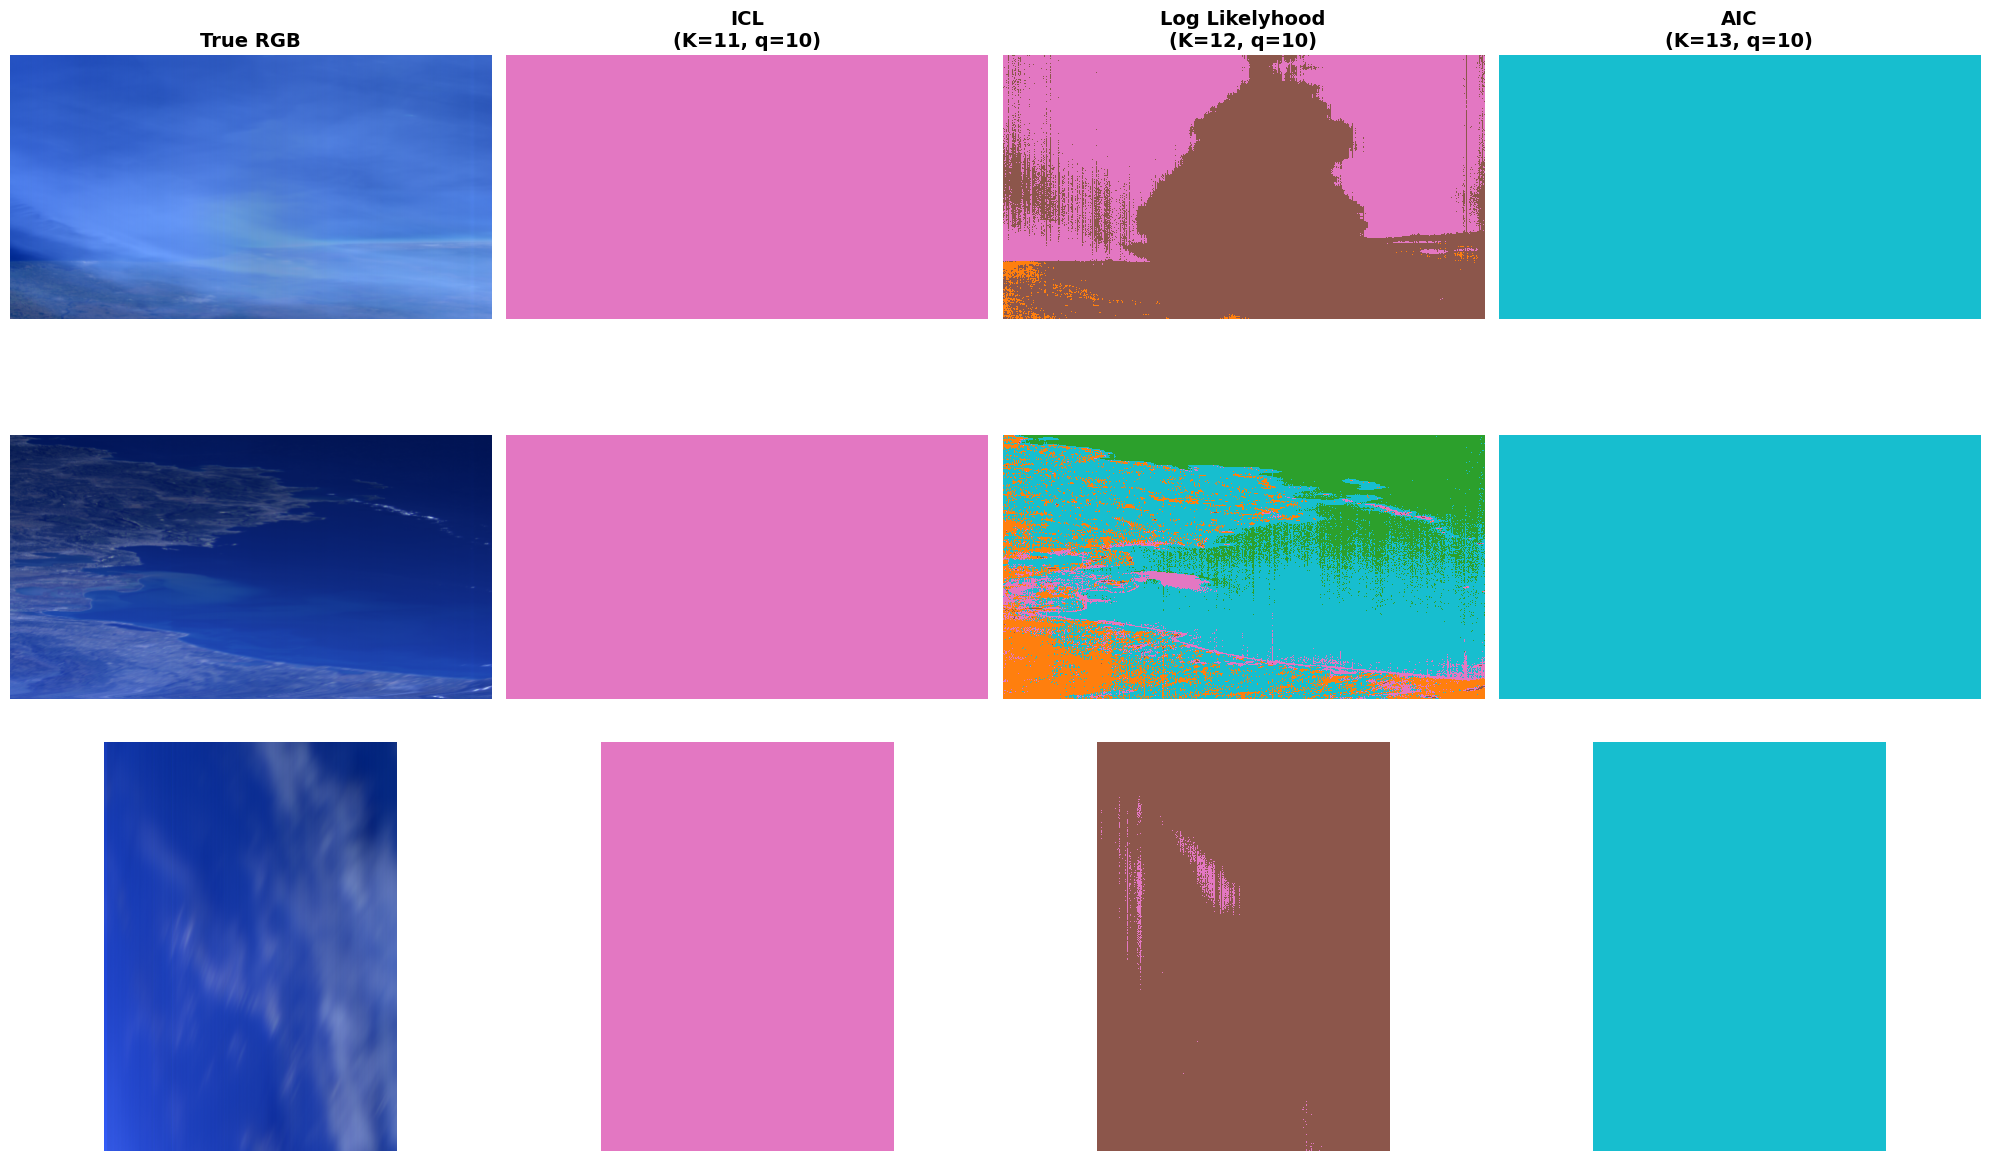

In [ ]:
import os

NUM_TEST_FILES = 3
num_test_files = min(NUM_TEST_FILES, len(data_dir))
print(f"Using {num_test_files} files for testing.")

# 1. Fetch all model files in the comparison folder
model_dir = "models/model_selection/"
# Finds all .pt files and sorts them alphabetically
model_files = sorted(glob.glob(os.path.join(model_dir, "*.pt")))
num_models = len(model_files)

print(f"Found {num_models} models in '{model_dir}'")

# Create the figure grid: h rows (images), w columns (1 RGB + num_models)
h = num_test_files
w = 1 + num_models

# Scale figure size dynamically based on the grid width/height
fig, axes = plt.subplots(h, w, figsize=(w * 5, h * 4))

# Ensure axes is a 2D array even if h=1 or w=1
if h == 1:
    axes = np.expand_dims(axes, axis=0)
if w == 1:
    axes = np.expand_dims(axes, axis=1)

# 2. Pre-load all models to avoid constantly reloading them inside the image loop
loaded_models = []
for model_file in model_files:
    mfa_state = torch.load(model_file, map_location=device)
    
    # Extract params
    K = mfa_state['hyperparameters']['n_components']
    q = mfa_state['hyperparameters']['n_factors']
    n_features = mfa_state['hyperparameters']['n_features']
    
    # Initialize Model
    mfa_model = MFA(n_components=K, n_features=n_features, n_factors=q, device=device)
    mfa_model.load_state_dict(mfa_state['model_state_dict'])
    mfa_model.eval()
    
    # Deduce the preprocessing method from filename string (safest approach)
    filename = os.path.basename(model_file)
    if "LL" in filename:
        model_title = f"Log Likelyhood\n(K={K}, q={q})"
    elif "BIC" in filename:
        model_title = f"BIC\n(K={K}, q={q})"
    elif "AIC" in filename:
        model_title = f"AIC\n(K={K}, q={q})"
    elif "ICL" in filename:
        model_title = f"ICL\n(K={K}, q={q})"
        
    loaded_models.append({
        'model': mfa_model,
        'state': mfa_state,
        'filename': filename,
        'title': model_title
    })

# Loop over the test images
for i in range(num_test_files):
    file = test_data_dir[i]
    print(f"Processing file {i+1}/{num_test_files}: {file}")

    satobj = Hypso(file) 

    # Load the full image data
    match data_product:
        case DataProduct.L1A:
            image = satobj.l1a_cube.values.astype(np.float32)
        case DataProduct.L1B:
            image = satobj.l1b_cube.values.astype(np.float32)
        case DataProduct.L1D:
            image = satobj.l1d_cube.values.astype(np.float32)
        case _:
            raise ValueError(f"Unknown data product: {data_product}")

    img_h, img_w, b = image.shape
    data_2d_full = image.reshape(-1, b)
    data_2d_full_tensor = torch.tensor(data_2d_full, dtype=torch.float32).to(device)

    # Get and Plot RGB Representation
    rgb_bands = [70, 50, 20]
    rgb_img = image[:, :, rgb_bands]
    # Normalize RGB for display
    rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
    
    axes[i, 0].imshow(rgb_img, aspect='equal')
    axes[i, 0].axis('off')
    if i == 0:
        axes[i, 0].set_title("True RGB", fontweight='bold', fontsize=14)

    # 4. Iterate through loaded models and plot classifications row-by-row
    for j, model_info in enumerate(loaded_models):
        mfa_model = model_info['model']
        mfa_state = model_info['state']
        filename = model_info['filename']
        
        #norms = torch.norm(data_2d_full_tensor, p=2, dim=1, keepdim=True)
        #epsilon = 1e-8
        #processed_image = (data_2d_full_tensor / (norms + epsilon))
        processed_image = data_2d_full_tensor.float()

        # Run Inference
        with torch.no_grad():
            log_resp, _ = mfa_model.e_step(processed_image)
            responsibilities = torch.exp(log_resp)
            new_cluster_ids = torch.argmax(responsibilities, dim=1)
            
        seg_map = new_cluster_ids.reshape(img_h, img_w).cpu().numpy()
        
        # Plot Classification Map
        # vmin=0, vmax=9 ensures stable tab10 colors across different models
        axes[i, j + 1].imshow(seg_map, cmap='tab10', vmin=0, vmax=9, interpolation='nearest', aspect='equal')
        axes[i, j + 1].axis('off')
        
        # Add titles only to the top row to keep the grid clean
        if i == 0:
            axes[i, j + 1].set_title(model_info['title'], fontweight='bold', fontsize=14)

# Render the beautiful master plot
plt.tight_layout()
plt.show()

#### Loadings Plotting

Found 3 models in 'models/model_selection/'


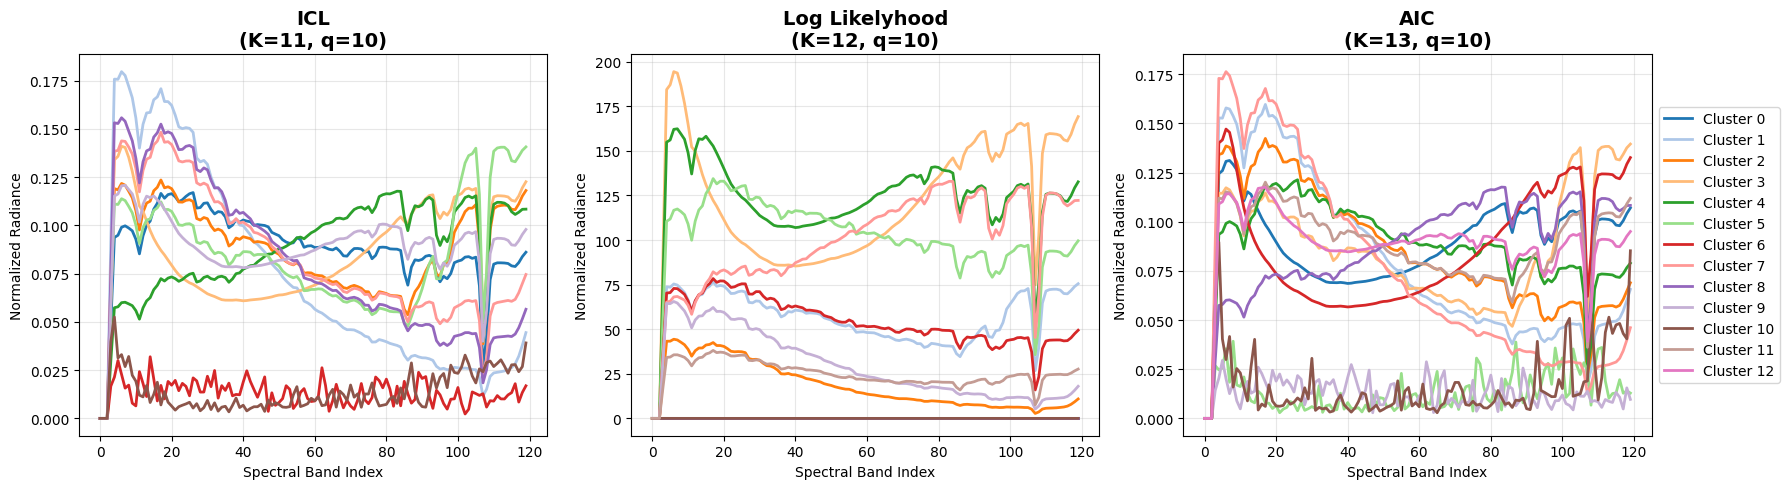

In [ ]:
# 1. Fetch all model files in the comparison folder
model_dir = "models/model_selection/"
model_files = sorted(glob.glob(os.path.join(model_dir, "*.pt")))
num_models = len(model_files)

print(f"Found {num_models} models in '{model_dir}'")

# Create the figure grid: 1 row, w columns (num_models)
# We use a 1D grid since we are just comparing line plots
fig, axes = plt.subplots(1, num_models, figsize=(num_models * 6, 5))

# Ensure axes is iterable even if there is only 1 model
if num_models == 1:
    axes = [axes]

# Grab the discrete 'tab20' colormap directly
cmap = plt.get_cmap('tab20')

# 2. Iterate through loaded models and plot signatures side-by-side
for j, model_file in enumerate(model_files):
    mfa_state = torch.load(model_file, map_location=device)
    
    # Extract params
    K = mfa_state['hyperparameters']['n_components']
    q = mfa_state['hyperparameters']['n_factors']
    n_features = mfa_state['hyperparameters']['n_features']
    
    # Initialize Model
    mfa_model = MFA(n_components=K, n_features=n_features, n_factors=q, device=device)
    mfa_model.load_state_dict(mfa_state['model_state_dict'])
    mfa_model.eval()
    
    # Extract learned means
    with torch.no_grad():
        learned_means = mfa_model.mu.cpu().numpy()
    
    filename = os.path.basename(model_file)
    
    # De-process the signatures based on filename string
    if "LL" in filename:
        title = f"Log Likelyhood\n(K={K}, q={q})"
        physical_means = learned_means
        ylabel = "Normalized Radiance"
        
    elif "BIC" in filename:
        title = f"BIC\n(K={K}, q={q})"
        physical_means = learned_means
        ylabel = "Normalized Radiance"
        
    elif "AIC" in filename:
        title = f"AIC\n(K={K}, q={q})"
        physical_means = learned_means
        ylabel = "Normalized Radiance"
        
    elif "ICL" in filename:
        title = f"ICL\n(K={K}, q={q})"
        physical_means = learned_means
        ylabel = "Normalized Radiance"
    else:
        print(f"Warning: Could not deduce preprocessing method from filename '{filename}'. Plotting raw learned means.")
        title = f"Unknown Preprocessing\n(K={K}, q={q})"
        physical_means = learned_means
        ylabel = "Normalized Radiance"
            
    # Plot each cluster's mean spectral signature
    ax = axes[j]
    for k in range(K):
        ax.plot(physical_means[k], label=f'Cluster {k}', color=cmap.colors[k], linewidth=2)
        
    ax.set_title(title, fontweight='bold', fontsize=14)
    ax.set_xlabel("Spectral Band Index")
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    
    # Only show legend on the right-most plot to avoid clutter
    if j == num_models - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()